In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

class RBM(nn.Module):
    def __init__(self, n_vis, n_hid, k=1):
        super(RBM, self).__init__()
        self.W = nn.Parameter(torch.randn(n_hid, n_vis) * 0.01)
        self.h_bias = nn.Parameter(torch.zeros(n_hid))
        self.v_bias = nn.Parameter(torch.zeros(n_vis))
        self.k = k  # CD-k

    def sample_h(self, v):
        p_h = torch.sigmoid(F.linear(v, self.W, self.h_bias))
        return p_h.bernoulli(), p_h

    def sample_v(self, h):
        p_v = torch.sigmoid(F.linear(h, self.W.t(), self.v_bias))
        return p_v.bernoulli(), p_v

    def forward(self, v):
        h_sample, _ = self.sample_h(v)
        for _ in range(self.k):
            v_sample, _ = self.sample_v(h_sample)
            h_sample, _ = self.sample_h(v_sample)
        return v_sample

    def contrastive_divergence(self, v, lr=0.1):
        h0, p_h0 = self.sample_h(v)
        v_k = v
        for _ in range(self.k):
            h_k, _ = self.sample_h(v_k)
            v_k, _ = self.sample_v(h_k)
        h_k, p_hk = self.sample_h(v_k)

        # Parameter update
        self.W.data += lr * (torch.matmul(p_h0.t(), v) - torch.matmul(p_hk.t(), v_k)) / v.size(0)
        self.v_bias.data += lr * torch.sum(v - v_k, dim=0) / v.size(0)
        self.h_bias.data += lr * torch.sum(p_h0 - p_hk, dim=0) / v.size(0)

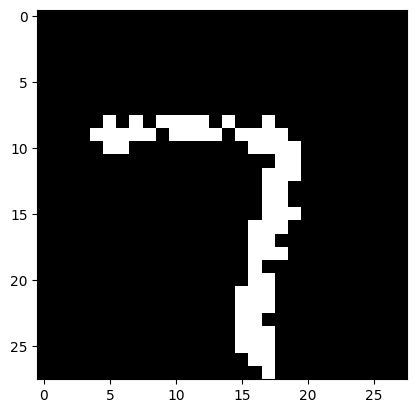

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.view(-1))  # flatten 28x28 -> 784
])

train_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=1000, shuffle=False)

batch, _ = next(iter(train_loader))
batch_sampled = batch.bernoulli()

plt.imshow(batch_sampled[0].reshape(28, 28), cmap='gray')
plt.show()

In [45]:
rbm = RBM(784, 256, k=1)
epochs = 5

for epoch in range(epochs):
    total_loss = 0
    for batch, _ in train_loader:
        batch = batch.bernoulli()  # Binarize input
        v_recon = rbm.forward(batch)
        loss = torch.mean((batch - v_recon) ** 2)
        total_loss += loss.item()
        rbm.contrastive_divergence(batch, lr=0.1)
    print(f"Epoch {epoch+1}, Loss: {total_loss/len(train_loader):.4f}")

Epoch 1, Loss: 0.0983
Epoch 2, Loss: 0.0706
Epoch 3, Loss: 0.0634
Epoch 4, Loss: 0.0594
Epoch 5, Loss: 0.0567


In [43]:
def extract_features(loader, rbm):
    features = []
    labels = []
    for batch, target in loader:
        with torch.no_grad():
            _, hidden = rbm.sample_h(batch)
        features.append(hidden)
        labels.append(target)
    return torch.cat(features), torch.cat(labels)

train_X, train_y = extract_features(train_loader, rbm)
test_X, test_y = extract_features(test_loader, rbm)

In [ ]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(max_iter=100)
clf.fit(train_X.numpy(), train_y.numpy())

from sklearn.metrics import accuracy_score
pred = clf.predict(test_X.numpy())
print("Test Accuracy:", accuracy_score(test_y.numpy(), pred))

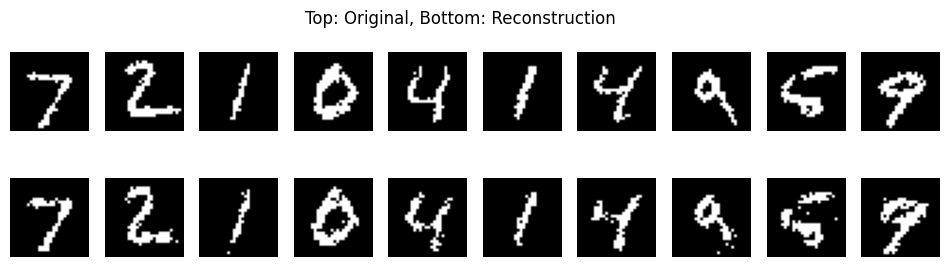

In [46]:
def show_reconstruction(rbm, data_loader):
    for batch, _ in data_loader:
        batch = batch.bernoulli()
        recon = rbm.forward(batch)
        break

    fig, axes = plt.subplots(2, 10, figsize=(12, 3))
    for i in range(10):
        axes[0, i].imshow(batch[i].view(28, 28), cmap='gray')
        axes[1, i].imshow(recon[i].view(28, 28).detach(), cmap='gray')
        axes[0, i].axis('off')
        axes[1, i].axis('off')
    plt.suptitle("Top: Original, Bottom: Reconstruction")
    plt.show()

show_reconstruction(rbm, test_loader)